<a href="https://colab.research.google.com/github/chaos44/generative_deep_learning/blob/main/chap7/7_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone -b tensorflow_2 https://github.com/davidADSP/GDL_code.git

Cloning into 'GDL_code'...
remote: Enumerating objects: 391, done.
remote: Total 391 (delta 0), reused 0 (delta 0), pack-reused 391
Receiving objects: 100% (391/391), 22.13 MiB | 35.19 MiB/s, done.
Resolving deltas: 100% (237/237), done.


In [2]:
cd GDL_code/

/content/GDL_code


In [5]:
pip install --upgrade music21

     |████████████████████████████████| 19.2MB 165kB/s 
  Created wheel for music21: filename=music21-6.3.0-cp36-none-any.whl size=21888021 sha256=f4a2ededb2290ae7a2fdcceb81529c7690f0966a80aa3dc0672f295c6a69c391
  Stored in directory: /root/.cache/pip/wheels/02/e8/2c/eed32afec2b6c6f945a17280c4e4df1cf2e8cd15ebe1025680
Successfully built music21
  Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0


In [6]:
from music21 import converter, chord, note

## **MuseGAN Training**
### **imports**
※ https://github.com/czhuang/JSB-Chorales-dataset/blob/master/Jsb16thSeparated.npz　を/GDL_code/data/chorales/に入れてから実行

In [38]:
import os
import matplotlib.pyplot as plt
import numpy as np
import types

from models.MuseGAN import MuseGAN
from utils.loaders import load_music


from music21 import midi
from music21 import note, stream, duration

In [42]:
# run params
SECTION = 'compose'
RUN_ID = '0017'
DATA_NAME = 'chorales'
FILENAME = 'Jsb16thSeparated.npz'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])



if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))
    os.mkdir(os.path.join(RUN_FOLDER, 'samples'))

mode =  'build' # ' 'load' #

### **data**

In [45]:
BATCH_SIZE = 64
n_bars = 2
n_steps_per_bar = 16
n_pitches = 84
n_tracks = 4

data_binary, data_ints, raw_data = load_music(DATA_NAME, FILENAME, n_bars, n_steps_per_bar)
data_binary = np.squeeze(data_binary)

### **architecture**

In [46]:
gan = MuseGAN(input_dim = data_binary.shape[1:]
        , critic_learning_rate = 0.001
        , generator_learning_rate = 0.001
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 32
        , batch_size = BATCH_SIZE
        , n_tracks = n_tracks
        , n_bars = n_bars
        , n_steps_per_bar = n_steps_per_bar
        , n_pitches = n_pitches
        )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:                 
    gan.load_weights(RUN_FOLDER)

In [47]:
gan.chords_tempNetwork.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
temporal_input (InputLayer)  [(None, 32)]              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 1, 1, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 2, 1, 1024)        66560     
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 1, 1024)        4096      
_________________________________________________________________
activation_2 (Activation)    (None, 2, 1, 1024)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 2, 1, 32)          32800     
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 1, 32)        

In [48]:
gan.barGen[0].summary()

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bar_generator_input (InputLa [(None, 128)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              132096    
_________________________________________________________________
batch_normalization_10 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_12 (Activation)   (None, 1024)              0         
_________________________________________________________________
reshape_12 (Reshape)         (None, 2, 1, 512)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 4, 1, 512)         524800    
_________________________________________________________________
batch_normalization_11 (Batc (None, 4, 1, 512)       

In [49]:
gan.generator.summary()

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
melody_input (InputLayer)       [(None, 4, 32)]      0                                            
__________________________________________________________________________________________________
chords_input (InputLayer)       [(None, 32)]         0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 32)           0           melody_input[0][0]               
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 32)           0           melody_input[0][0]               
______________________________________________________________________________________

In [50]:
gan.critic.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 2, 16, 84, 4)]    0         
_________________________________________________________________
conv3d (Conv3D)              multiple                  1152      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
conv3d_1 (Conv3D)            multiple                  16512     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    multiple                  0         
_________________________________________________________________
conv3d_2 (Conv3D)            multiple                  196736    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    multiple                 

### **training**

In [51]:
EPOCHS = 60
PRINT_EVERY_N_BATCHES = 10

gan.epoch = 0

In [52]:
gan.train(     
    data_binary
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
)

0 (5, 1) [D loss: (9.5)(R -0.4, F -0.0, G 1.0)] [G loss: -0.0]
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
1 (5, 1) [D loss: (-280.4)(R -366.4, F -3.2, G 8.9)] [G loss: -83.0]
2 (5, 1) [D loss: (-190.7)(R -184.2, F -17.2, G 1.1)] [G loss: -83.2]
3 (5, 1) [D loss: (-280.7)(R -318.8, F -14.2, G 5.2)] [G loss: -263.1]
4 (5, 1) [D loss: (-317.5)(R -478.6, F 8.3, G 15.3)] [G loss: -188.4]
5 (5, 1) [D loss: (291.2)(R 607.2, F -357.8, G 4.2)] [G loss: 22.7]
6 (5, 1) [D loss: (-262.4)(R -813.1, F 403.5, G 14.7)] [G loss: -728.9]
7 (5, 1) [D loss: (-206.9)(R -724.8, F 391.1, G 12.7)] [G loss: -621.4]
8 (5, 1) [D loss: (-143.6)(R -614.4, F 374.8, G 9.6)] [G loss: -526.2]
9 (5, 1) [D loss: (-94.1)(R -504.9, F 349.9, G 6.1)] [G loss: -447.8]
10 (5, 1) [D loss: (-60.3)(R -396.7, F 301.9, G 3.4)] [G loss: -367.8]
11 (5, 1) [D loss: (-46.2)(R -268.2, F 205.6, G 1.6)] [G loss: -245.2]
12 (5, 1) [D loss: (-49.7)(R -176.1, F 103.9,

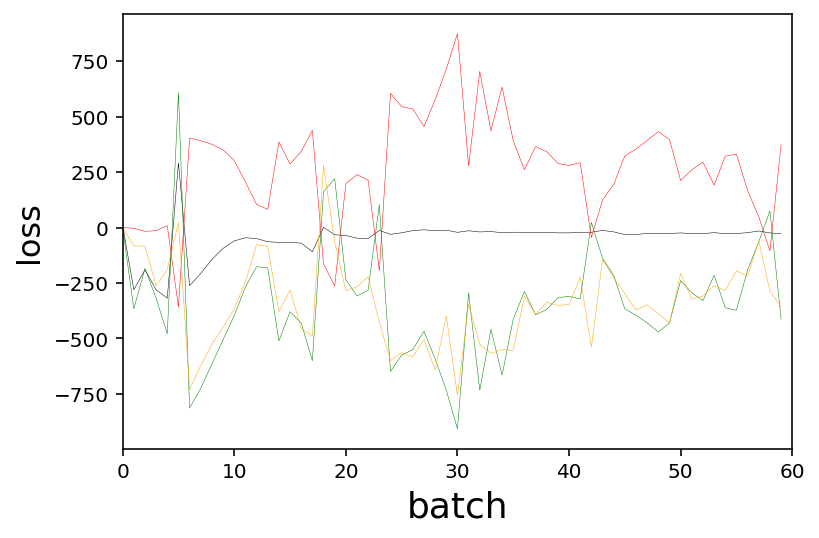

In [53]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)

plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='orange', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, len(gan.d_losses))
# plt.ylim(0, 2)

plt.show()